In [1]:
import os.path as osp
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

root_path = Path(osp.abspath("")).parents[0]
sys.path.append(str(root_path))
%config InlineBackend.figure_format='retina'

## Step 0: 设置环境

In [2]:
from core.toolpath import LinearPath
import utils.visualization as vis

Ts = 0.0005
V_MAX = 100
A_MAX = 3000
J_MAX = 60000
chord_error = 0.2
points = np.array([[2, 0], [4, 2], [2, 4], [0, 2], [2, 0]])

## Step 1: 生成线性路径

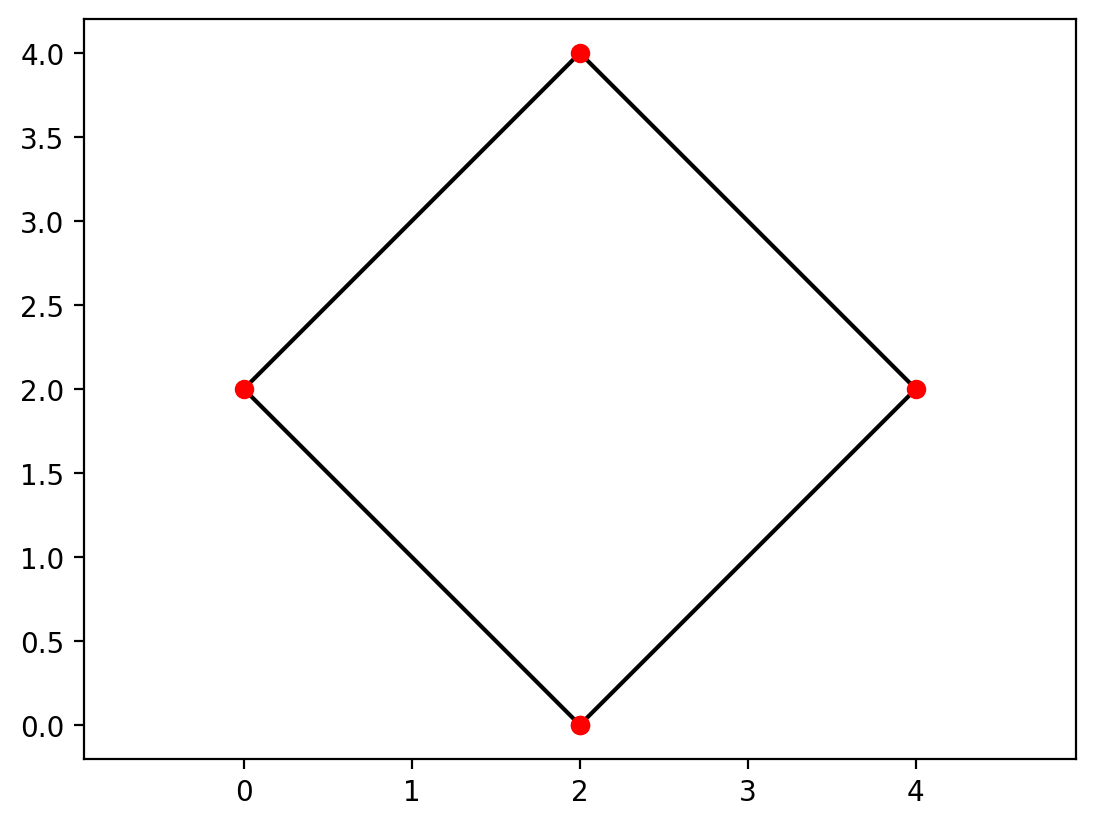

Total arc length: 11.313708498984761


In [3]:
path = LinearPath(points, chord_error)
vis.plot_path(path)
path_lengths = path.lengths
print(f"Total arc length: {np.sum(path_lengths)}")

## Step 2: 前瞻规划

通过双向扫描，计算每个连接点处的速度上界。

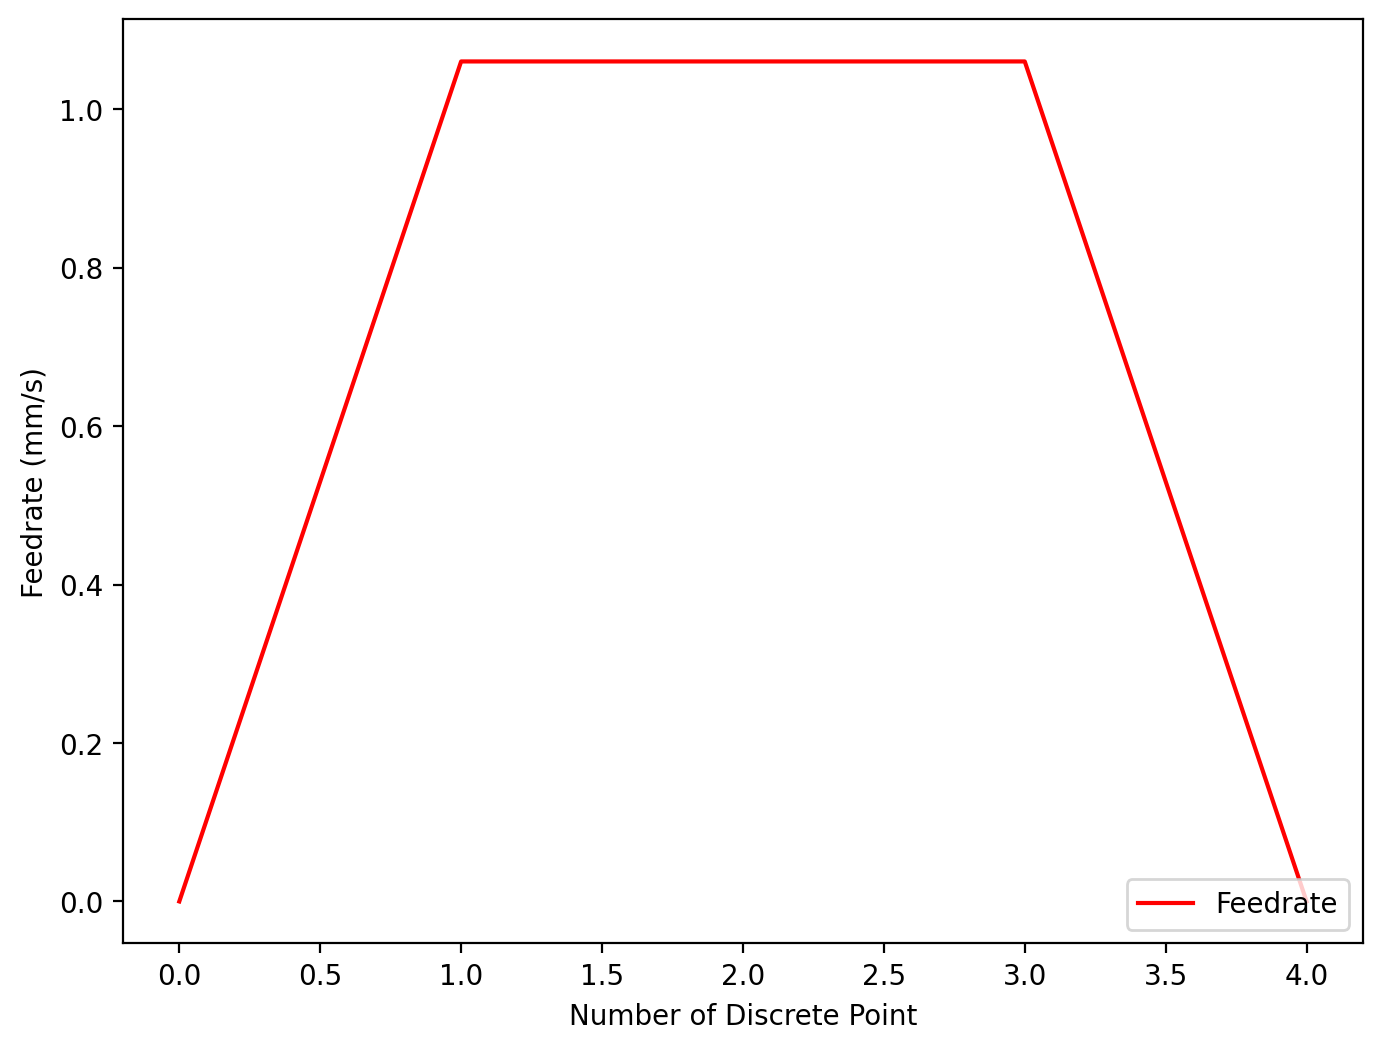

In [4]:
from core.look_ahead import BidirectionalScanner

scanner = BidirectionalScanner(path, Ts, V_MAX, A_MAX, J_MAX)
v_lim = scanner.v_limit
plt.figure(figsize=(8, 6))
plt.plot(v_lim, "r-", label="Feedrate")
plt.xlabel("Number of Discrete Point")
plt.ylabel("Feedrate (mm/s)")
plt.legend(loc="lower right")
plt.show()

## Step 3: 进给率规划

连接点使用 Step 2 中的速度上界，中间的速度使用双S形曲线进行规划

In [5]:
from core.feedrate_scheduler import FeedrateScheduler

scheduler = FeedrateScheduler(path_lengths, v_lim, V_MAX, A_MAX, J_MAX, Ts)
profiles = scheduler.profiles
print(f"Total time: {scheduler.total_time}")

Total time: 0.4538184804930624


获取整个路径上的速度曲线，并可视化

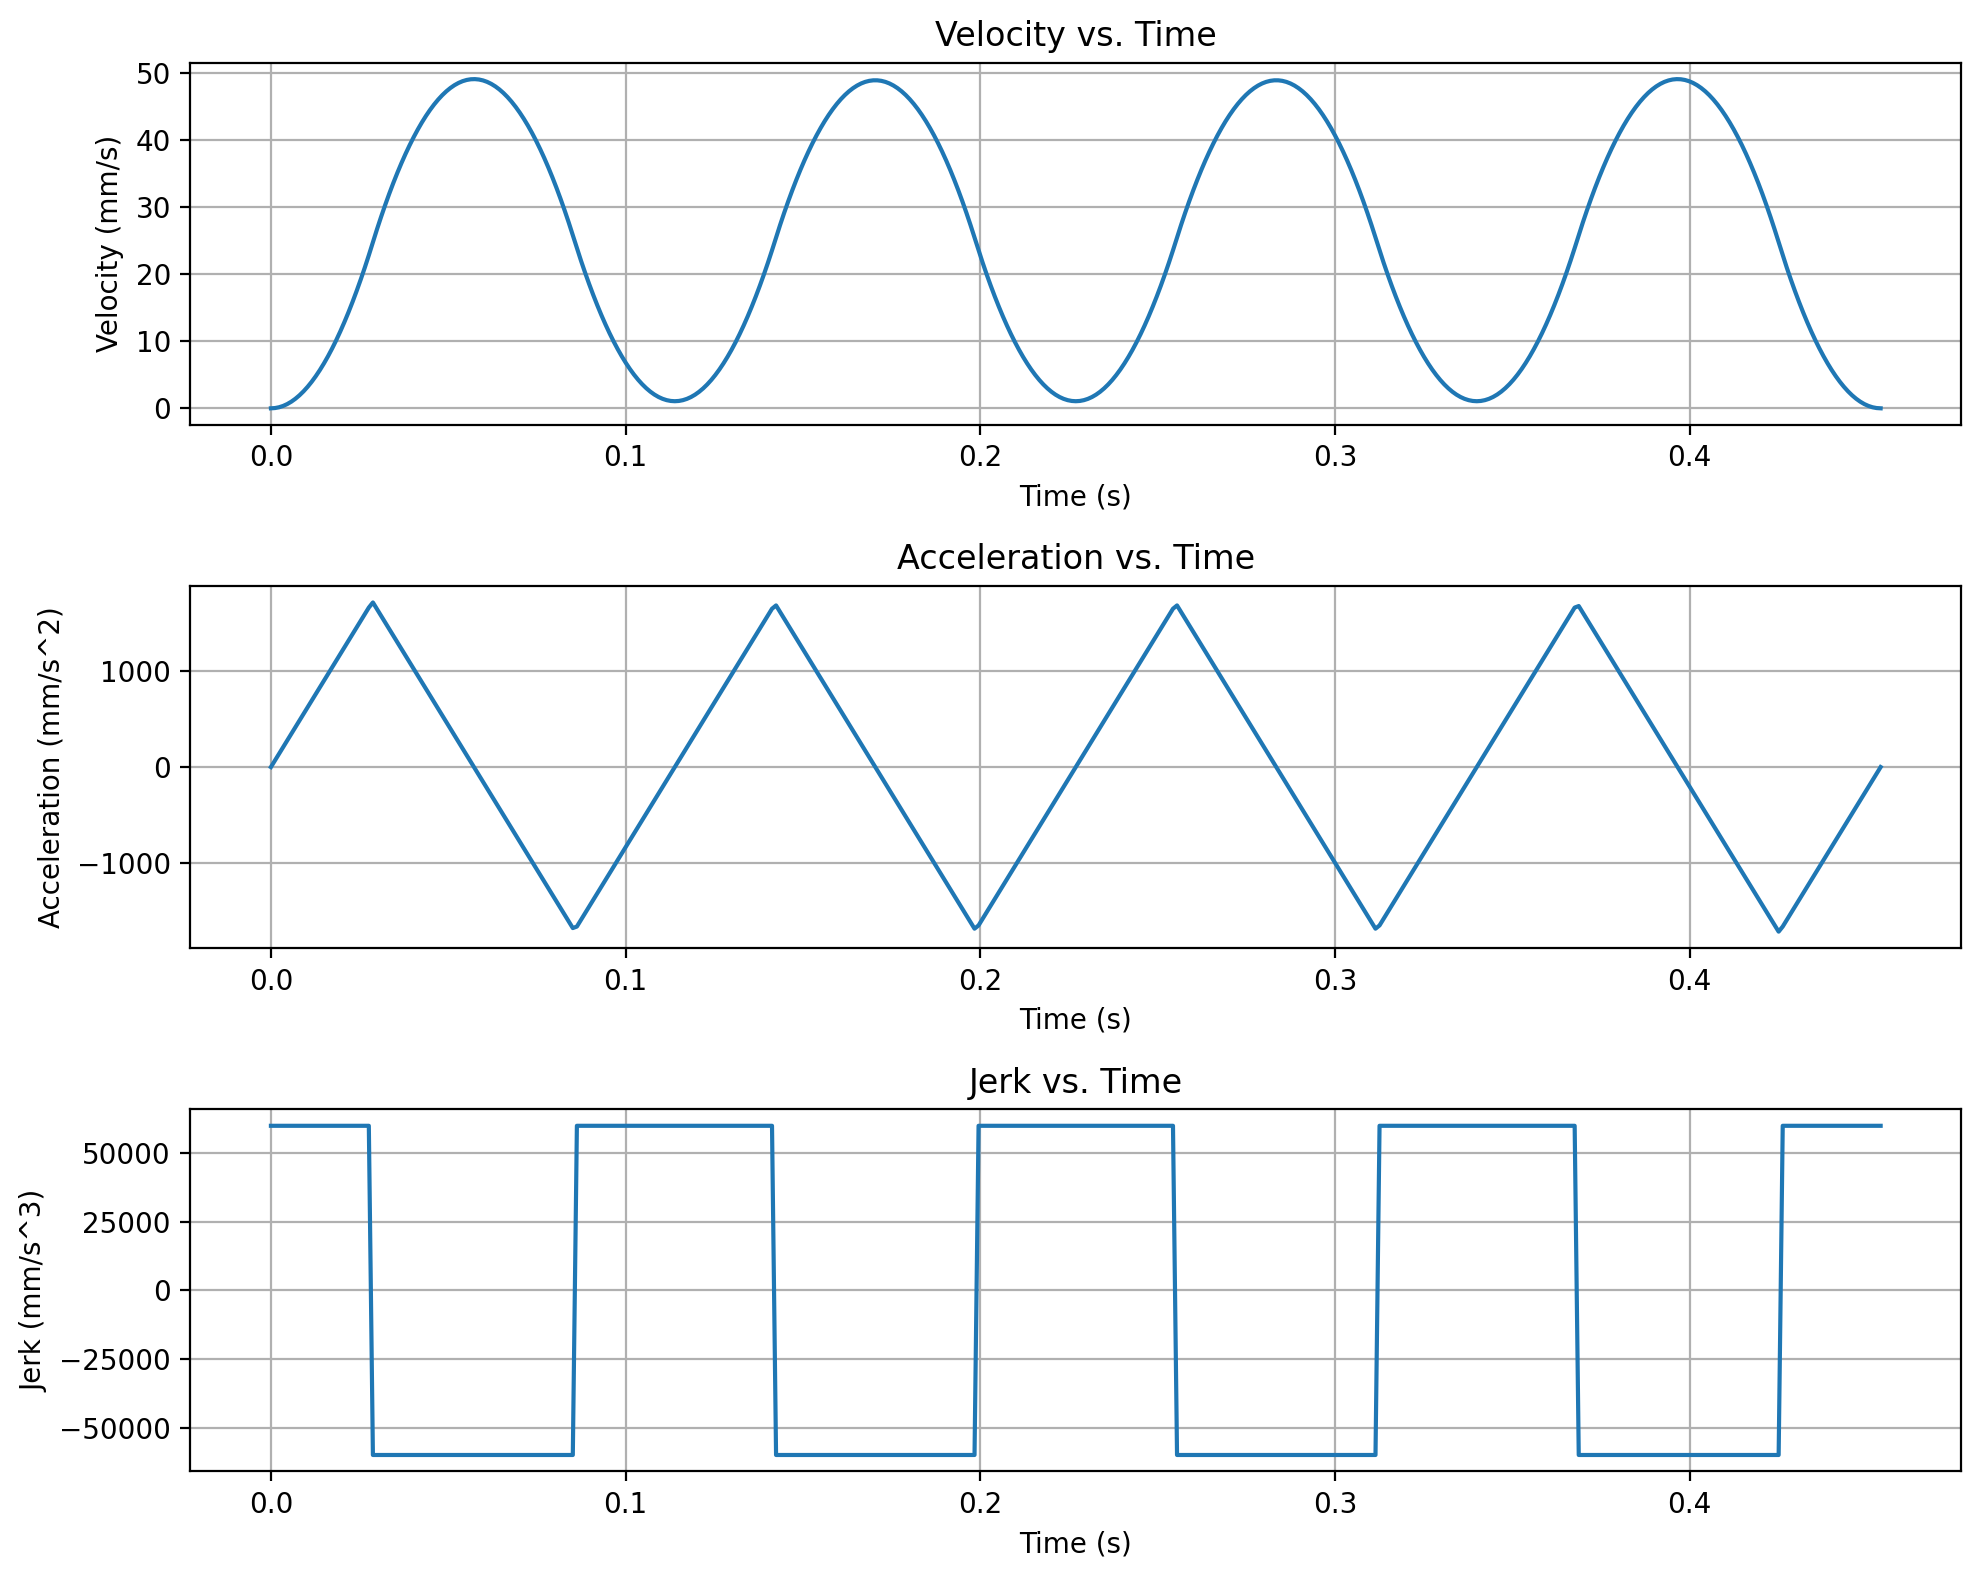

In [6]:
profile_data = scheduler.get_profile_data()
vis.plot_profiles(profile_data)

## Step 4: 插补

插补周期为 `Ts`，根据 Step3 计算该周期内的位移大小，然后以此为弧长，找到到轨迹曲线上对应的位置作为插补点

In [7]:
from core.interpolator import Interpolator

interpolator = Interpolator(path, scheduler, Ts)
interpolated_points = interpolator.interpolate()

由于插补点过于密集，因此每隔 `sampling_rate` 个插补点取一个进行可视化

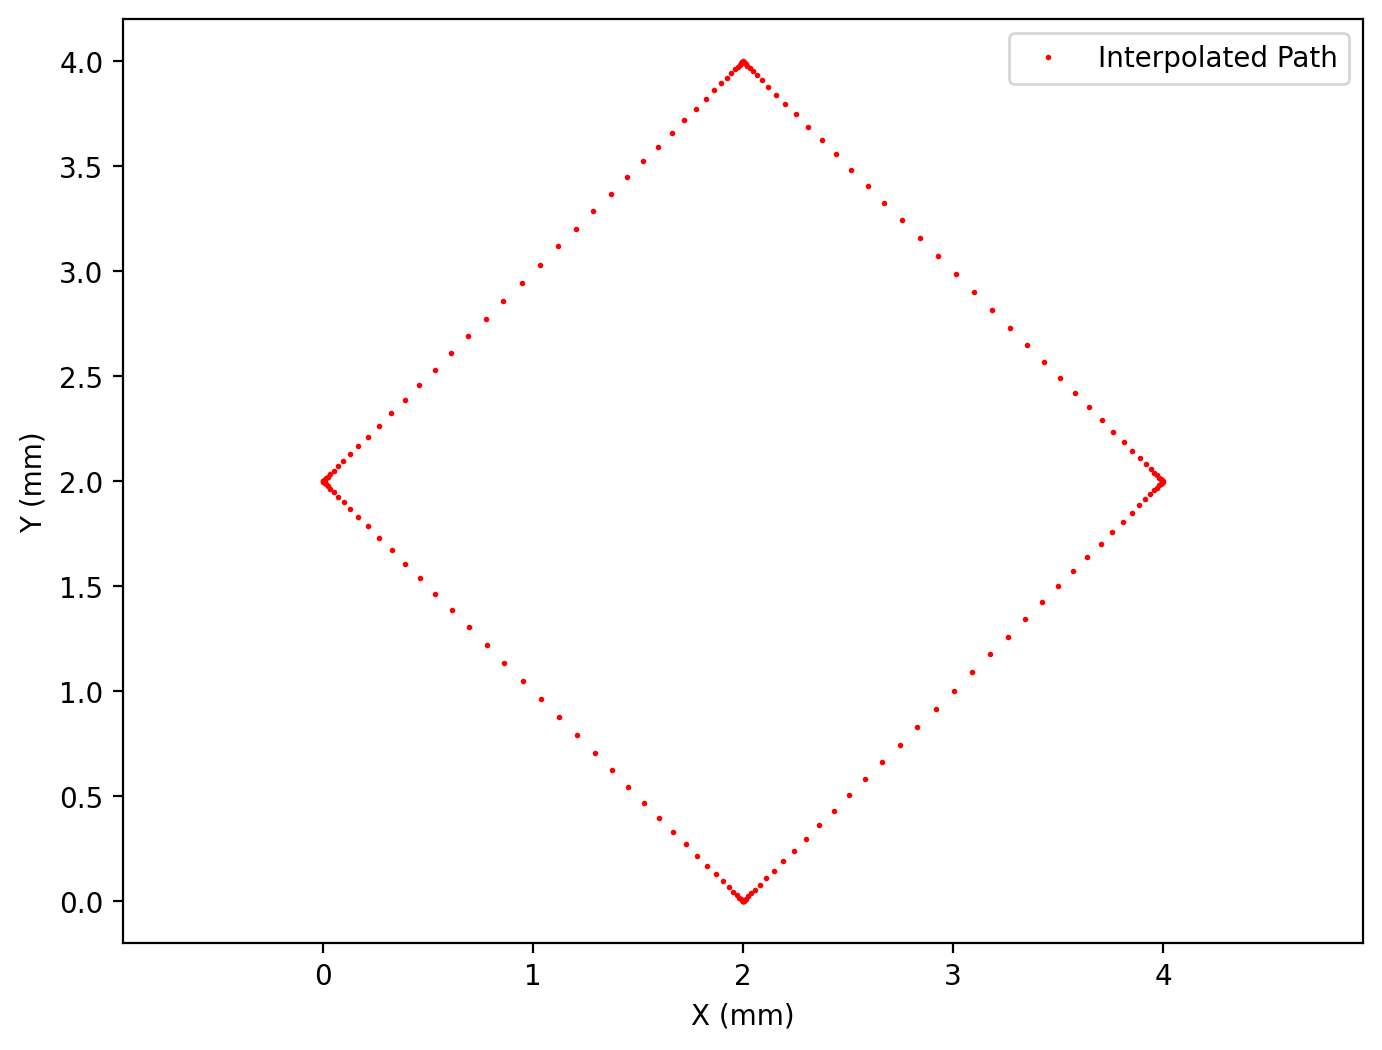

In [8]:
plt.figure(figsize=(8, 6))
sampling_rate = 5
downsampled_points = interpolated_points[::sampling_rate]
plt.plot(downsampled_points[:, 0], downsampled_points[:, 1], "r.", markersize=2, label="Interpolated Path")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.legend(loc="upper right")
plt.axis("equal")
plt.show()

## 使用 Zhao2013 算法进行路径平滑

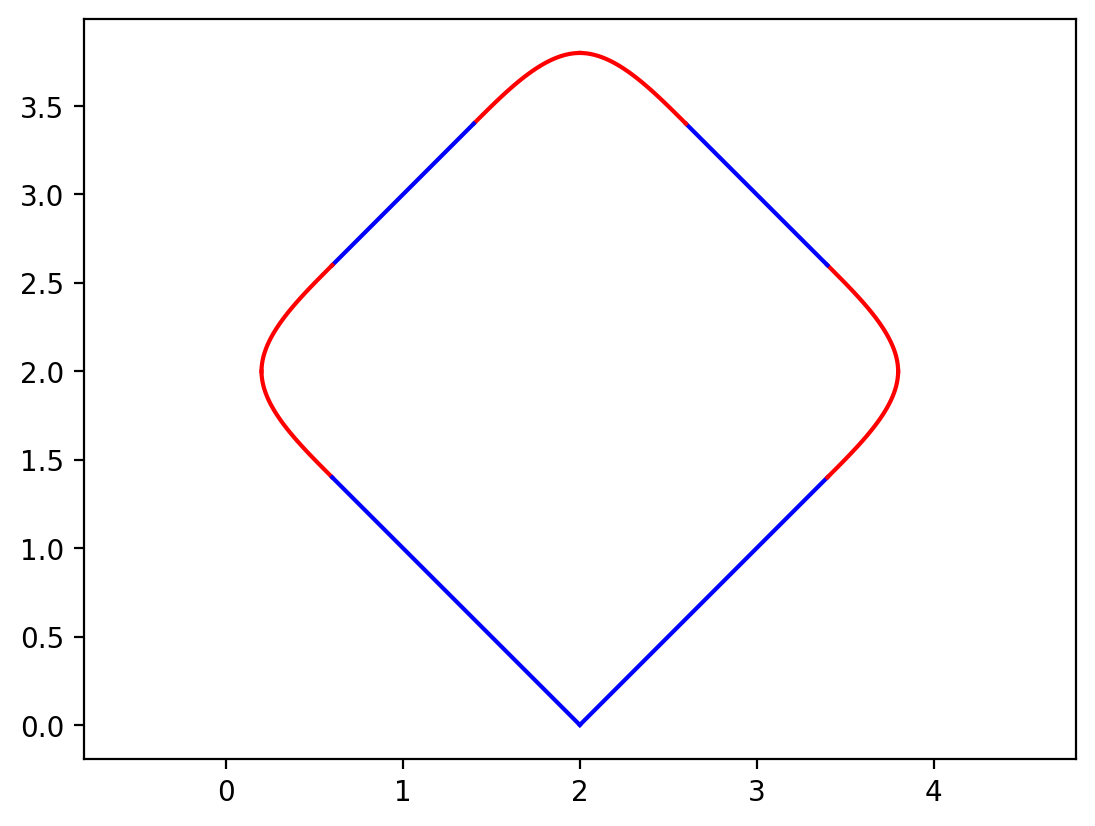

Total arc length: 10.650210985615088
Max curvature: 3.33333904737854


In [9]:
from papers.Zhao2013.algorithm import SmoothedPath

smooth_path = SmoothedPath(points, chord_error, 0.5)
vis.plot_toolpath(smooth_path)
smooth_path_lengths = smooth_path.lengths
print(f"Total arc length: {np.sum(smooth_path_lengths)}")
print(f"Max curvature: {np.max(smooth_path.curvature_peaks)}")

Total time: 0.36850743109574097


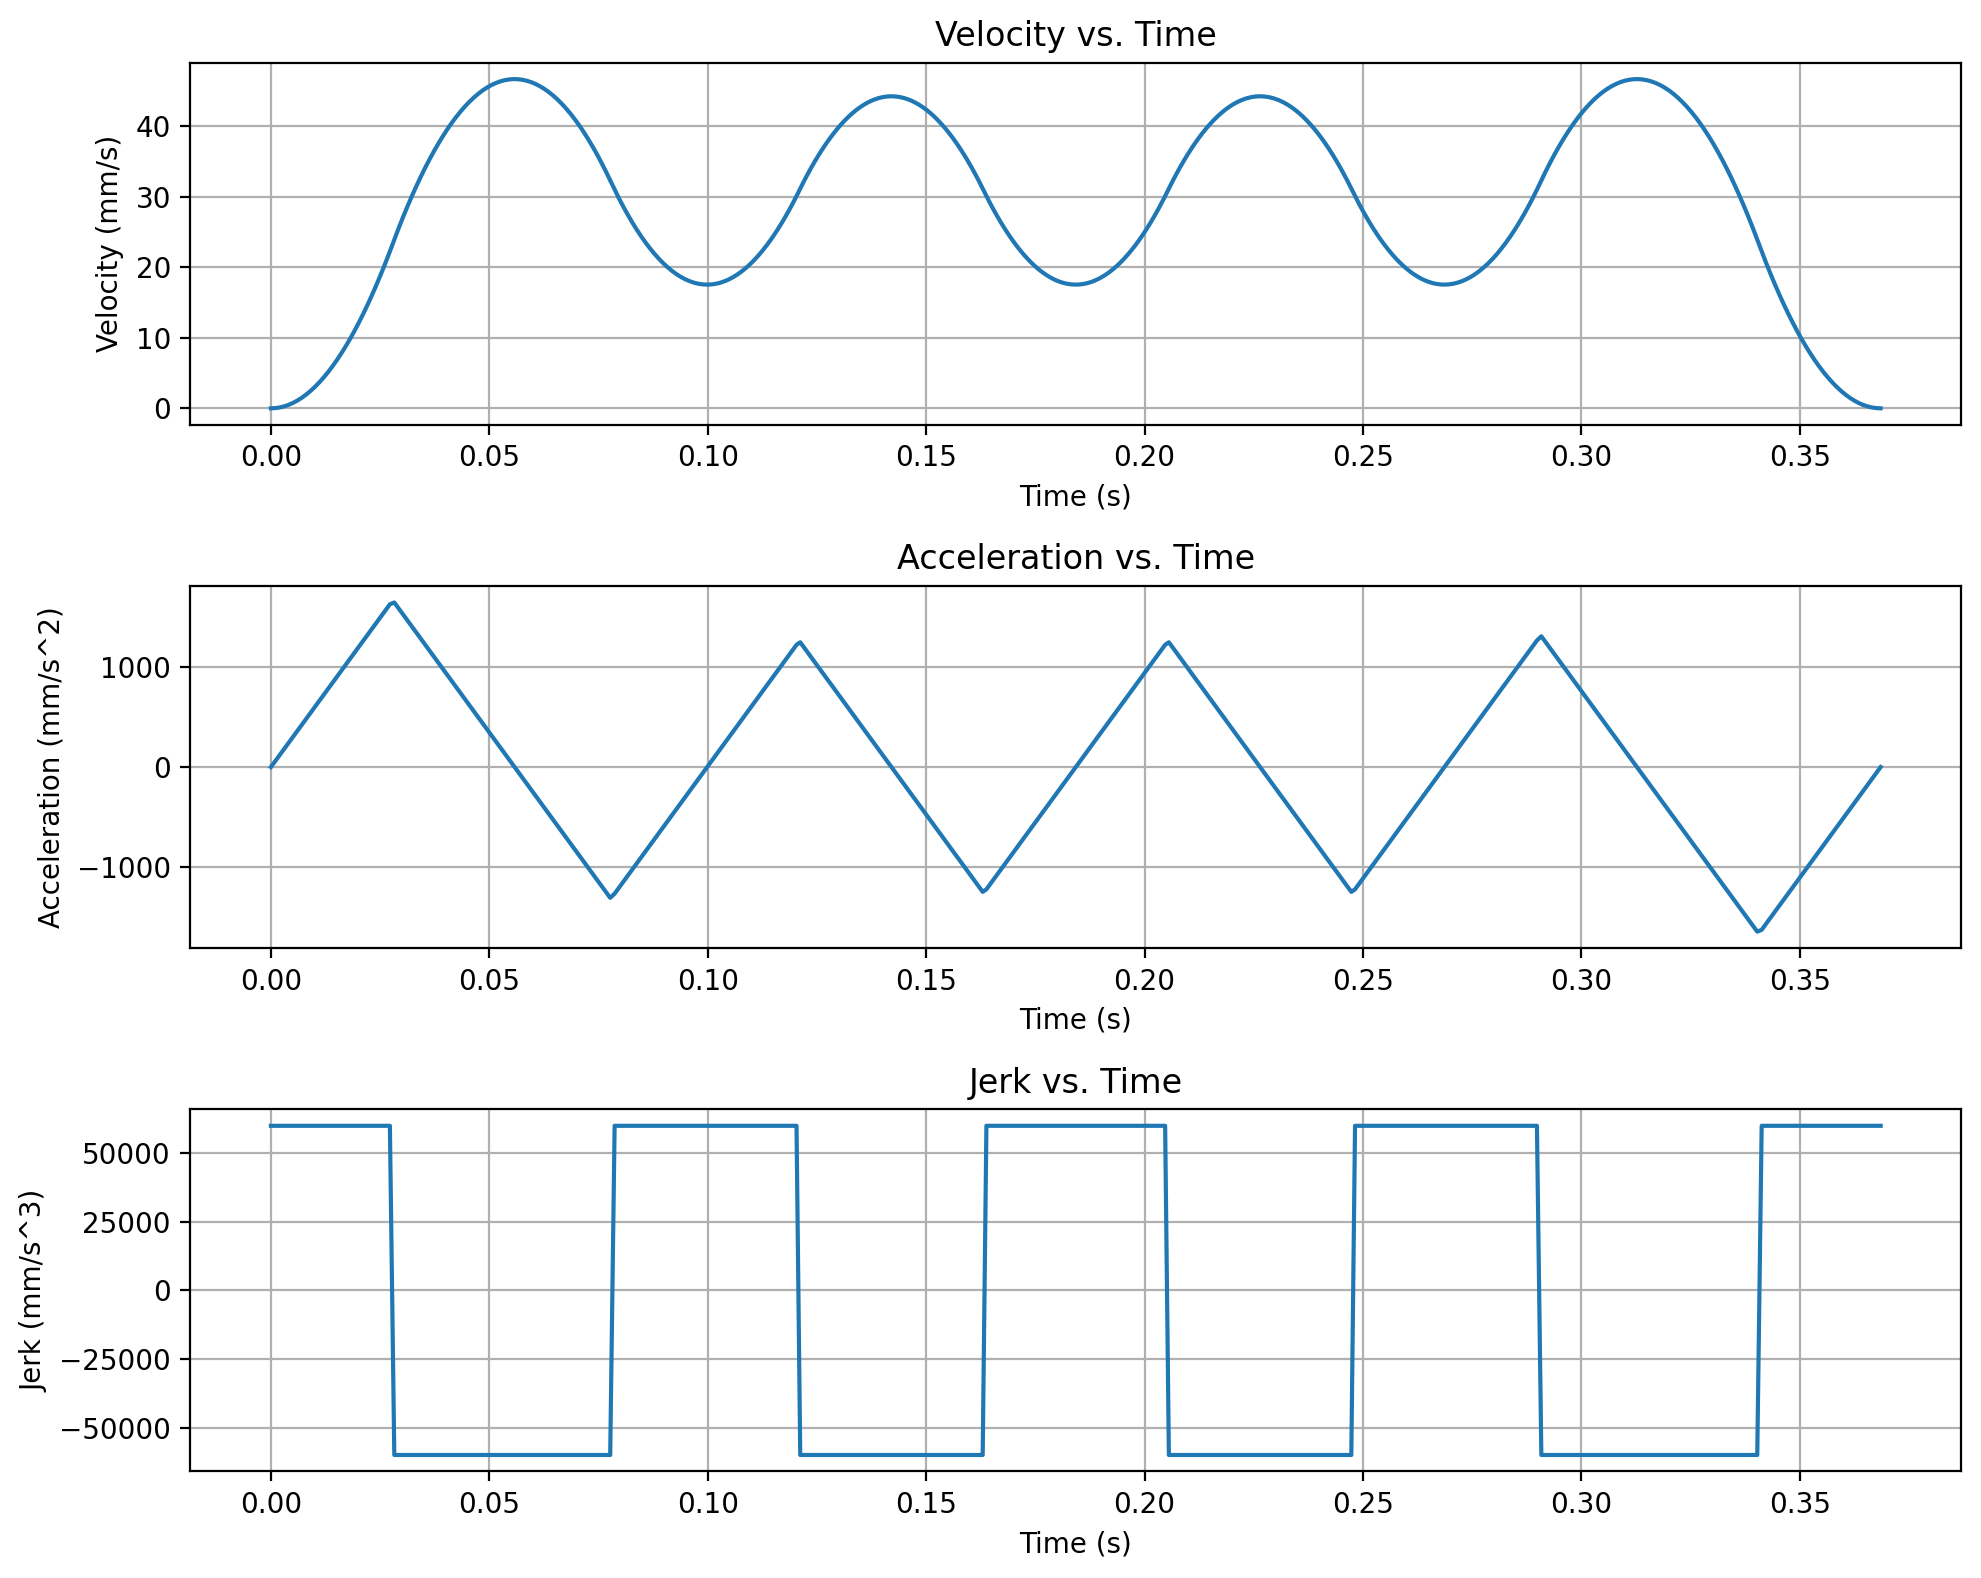

In [10]:
scanner_smooth = BidirectionalScanner(smooth_path, Ts, V_MAX, A_MAX, J_MAX)
v_lim_smooth = scanner_smooth.v_limit
smooth_scheduler = FeedrateScheduler(smooth_path_lengths, v_lim_smooth, V_MAX, A_MAX, J_MAX, Ts)
smooth_profiles = smooth_scheduler.profiles
print(f"Total time: {smooth_scheduler.total_time}")
smooth_profile_data = smooth_scheduler.get_profile_data()
vis.plot_profiles(smooth_profile_data)

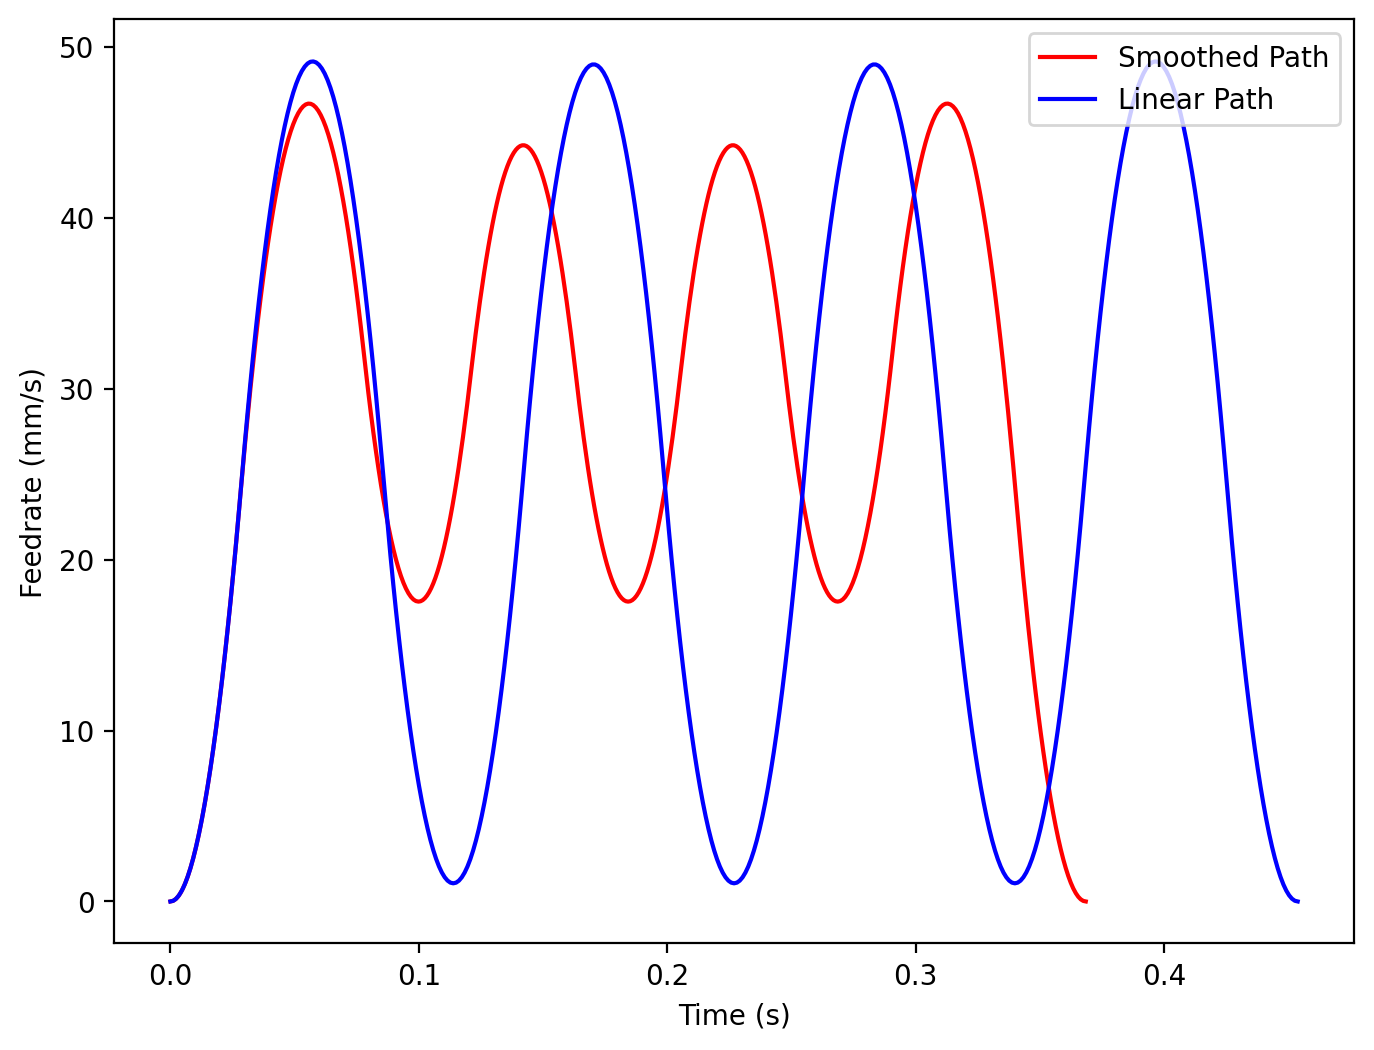

In [11]:
T_smooth, V_smooth = smooth_profile_data["T"], smooth_profile_data["V"]
T_linear, V_linear = profile_data["T"], profile_data["V"]
plt.figure(figsize=(8, 6))
plt.plot(T_smooth, V_smooth, "r-", label="Smoothed Path")
plt.plot(T_linear, V_linear, "b-", label="Linear Path")
plt.xlabel("Time (s)")
plt.ylabel("Feedrate (mm/s)")
plt.legend(loc="upper right")
plt.show()

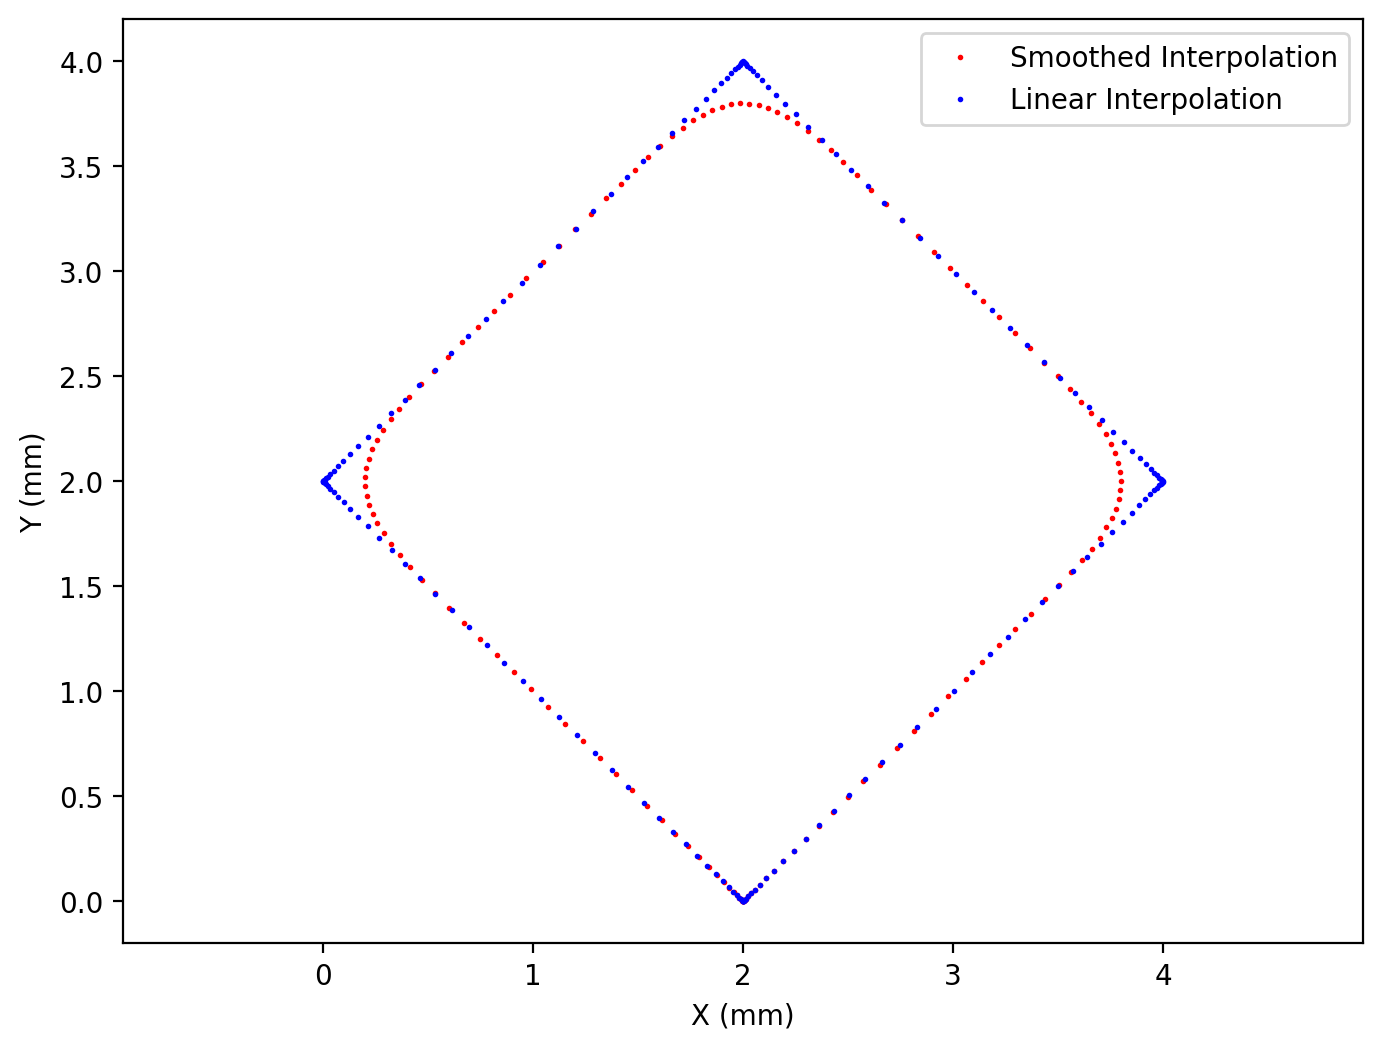

In [12]:
smooth_interpolator = Interpolator(smooth_path, smooth_scheduler, Ts)
smooth_interpolated_points = smooth_interpolator.interpolate()

plt.figure(figsize=(8, 6))
sampling_rate = 5
sampled_linear_pts = interpolated_points[::sampling_rate]
sampled_smooth_pts = smooth_interpolated_points[::sampling_rate]

plt.plot(sampled_smooth_pts[:, 0], sampled_smooth_pts[:, 1], "r.", markersize=2, label="Smoothed Interpolation")
plt.plot(sampled_linear_pts[:, 0], sampled_linear_pts[:, 1], "b.", markersize=2, label="Linear Interpolation")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.legend(loc="upper right")
plt.axis("equal")
plt.show()